##### Title: Box Jenkins Methods

Author: Chris Hyland／Yiran Jing

Date: 16-10-2018

##### Summary



In [2]:
from collections import Counter
import pandas as pd
import csv
import pprint
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from collections import defaultdict
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas import Series
from matplotlib import pyplot
from time_series import ts_plot,ts_plot2,ts_plot3,acf_pacf_plot,hist,modify_time_format,epoch_seconds_to_timestamp

from time_series import pd_read_obs_csv # function used for read SA weather obs
import statsmodels.api as sm
import seaborn as sns
import datetime
import glob, os
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
# product_of_interest = [1111087398, 1111087395, 1111087396]
train_data = pd.read_csv('../../intellify_data/Train_data.csv')
val_data = pd.read_csv('../../intellify_data/Val_data.csv')

train_data = train_data.set_index("Date")
val_data = val_data.set_index("Date")

# EDA
- time series plot
- time decomposition

Please refer to Models_1_VAR notebook to view the data wrangling and earlier analysis. We are only working with 3 products of interest. 

They are pizza within the top 5 high correlation

### Time decomposition 
Three products have quite simliar results, so just show one here. see model_1.

** High degree of seasonality** here.

The seasonal variation seems not proportional to the trend, therefore we use the **additive model**

# Model selection

The followllig parts include :

1. RW
2. Seasonal/quarter RW 
3. Exponentional Smoothing
4. Additive holt winters 
5. ARMA (seleced optimal p and q)
7. Seasonal ARMA

# Model validation and Forecast

### Real time forecast
At each preiod t, we use **all availiable** data to estimate the model and then preodict the future

** One-step ahead forecast**

Start at time $t = n$, use all abservations from $t = 1 : t$ to estimate model, and then use the estimated model to forecast $y_{t+1}$, then repeat the above step for multiple times. Then, compulate the forecast accuracy measures



Two schemes for updating the estimation sample at each validation period
- **Expanding window ** At each step, add the latest observation to the estimation sample
- **Rolling window ** The most common approach: At each step, use only the most recent n observation for estimation. This method implicitly assumes that the dynamtics of the series has a time changing nature, so the data far in the past are less relevant for estimation

To be more informative and comfident, we use both of them and compare the results for each model!

### Measuring forecast accuracy
How well the model perfoms on data not used in estimation, based on test dataset

### Point forecast (best guess)

##### Loss function
we want to minimise the predictive cost. We consider three common measures in business forecasting
##### RMSE

##### MAPE 
Recall that the mean precentage error is given by $$p_t = 100*(|(y_t - \hat{y_t})|/y_t) $$

Compared to RMSE, it has advantage of being **scale-independent**, but its disadvantage of being infinite or undefined if $y_t = 0 $ for any interested period t, and has extreme value when any $y_t$ close to 0.

#### MAE

### Interval Forecast
**Bootstrap CI**

In [4]:
products = ["Prod_one", "Prod_two", "Prod_three"]

# Model Selection

## Model 1: AR(1) Models
just to try things out initially.



On average, the AR(1) model is off by roughly 45%. Terrible performance, but it is to be expected.


## Model 2: Exponential smoothing

This model can be written as ARIMA(0,1,1).

### Summary of ES

** Have quite large errors around peak at Jan 2010, due to apparent shift**

If our model selection is based on the AIC, ES has slighly smaller AIC than ARMA(1, 0, 0) for three products, but unfortunately it has a bigger MAPE than AR(1). 

Seems a good estimation with a **shift**

White Noise but noticeable changes in variance aroud **Jan 2010**, where sales also show peaks

Thus, ES is good, but did bad just because 

Three products are similar patten

In [5]:
import forecast
#Removed weekends and holidays
ses_p1 = forecast.ses(train_data["Prod_one"])
ses_p1.fit()
ses_fitted_p1 = pd.Series(ses_p1.smooth(), index=train_data.index)
ses_resid_p1 = train_data["Prod_one"]-ses_fitted_p1

ses_p2 = forecast.ses(train_data["Prod_two"])
ses_p2.fit()
ses_fitted_p2 = pd.Series(ses_p2.smooth(), index=train_data.index)
ses_resid_p2 = train_data["Prod_two"]-ses_fitted_p2

ses_p3 = forecast.ses(train_data["Prod_three"])
ses_p3.fit()
ses_fitted_p3 = pd.Series(ses_p3.smooth(), index=train_data.index)
ses_resid_p3 = train_data["Prod_three"]-ses_fitted_p3


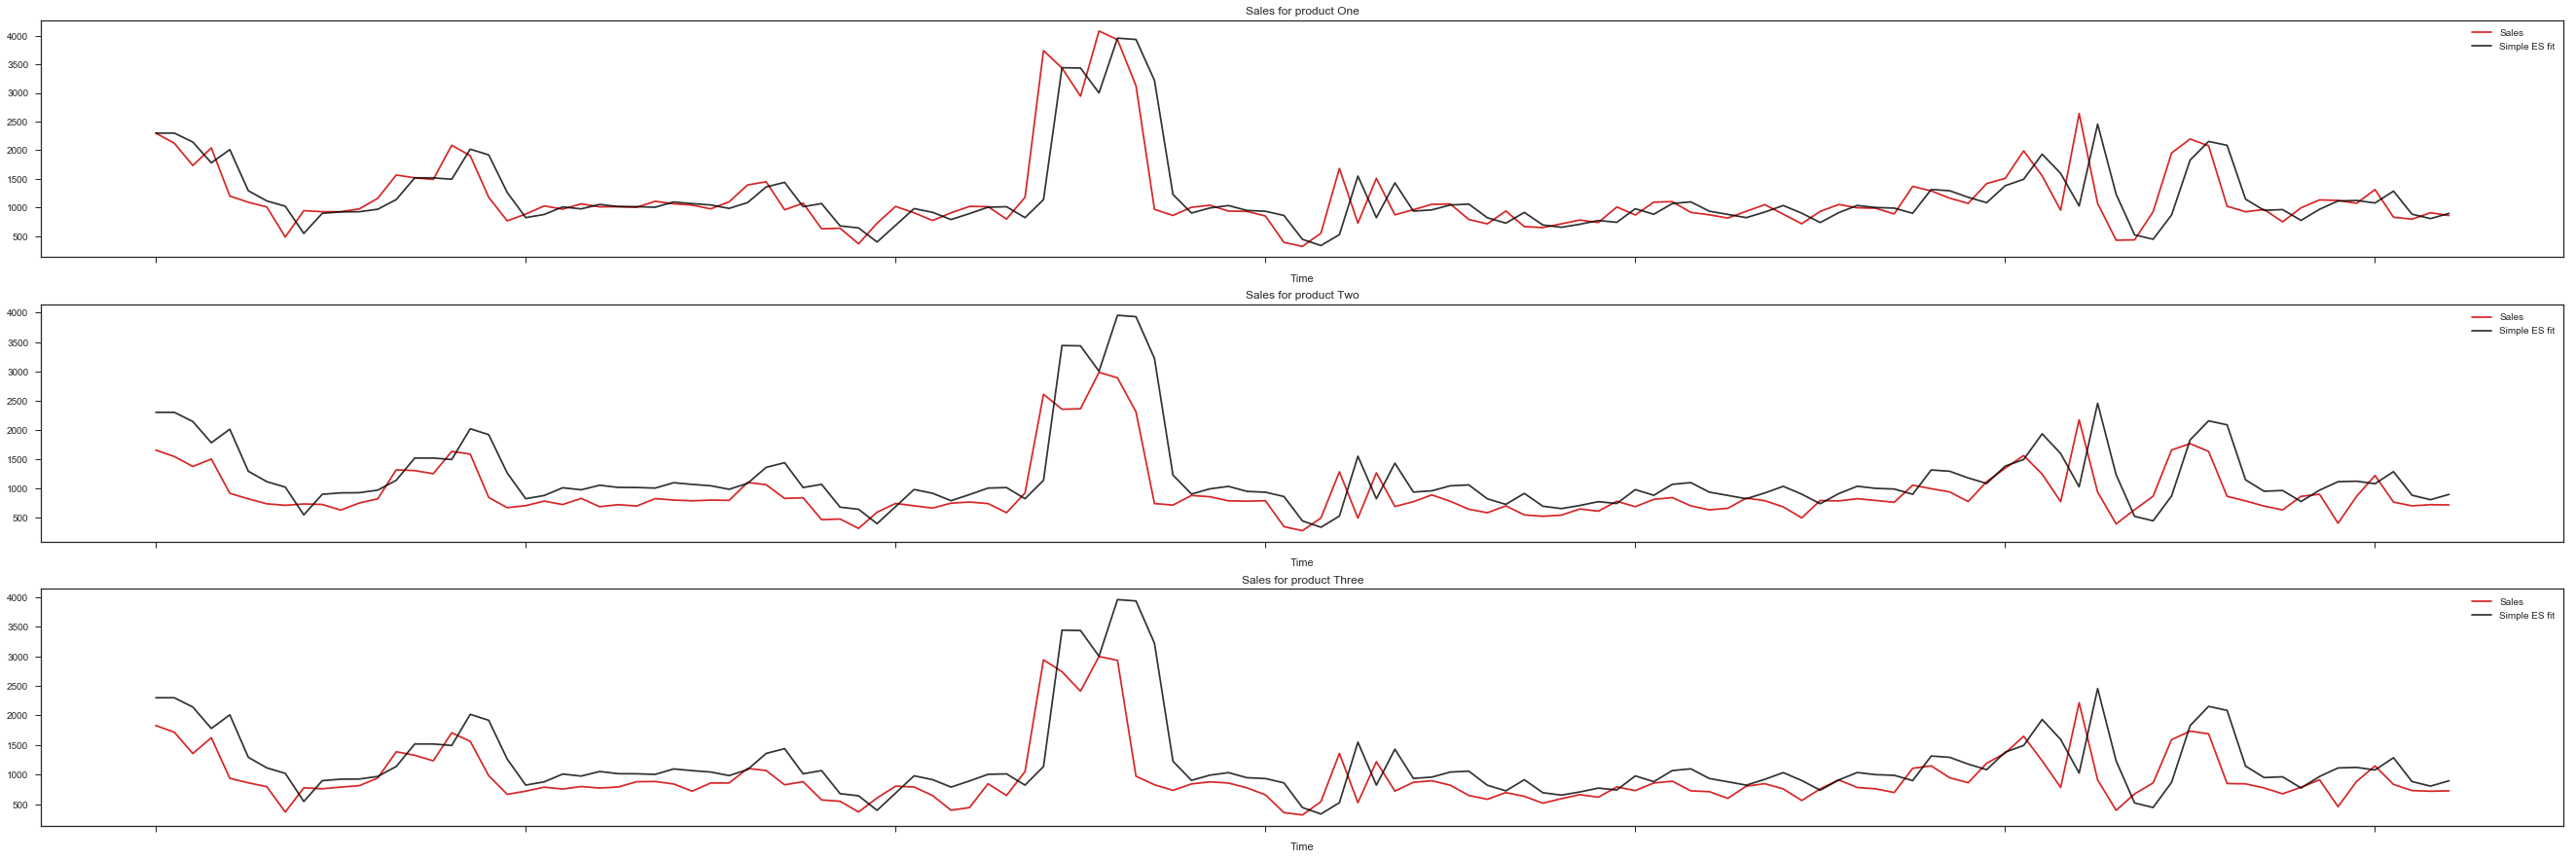

In [6]:
"""
Plot original data out.
"""
fig, axes = plt.subplots(nrows=1, ncols=3)

plt.subplot(3,1,1)
train_data["Prod_one"].plot(color=red, label='Sales')
ses_fitted_p1.plot(color='black', label='Simple ES fit', alpha=0.8)
plt.xlabel("Time")
plt.legend(loc='best')
plt.title("Sales for product One")

plt.subplot(3,1,2)
train_data["Prod_two"].plot(color=red, label='Sales')
ses_fitted_p1.plot(color='black', label='Simple ES fit', alpha=0.8)
plt.xlabel("Time")
plt.legend(loc='best')
plt.title("Sales for product Two")

plt.subplot(3,1,3)
train_data["Prod_three"].plot(color=red, label='Sales')
ses_fitted_p1.plot(color='black', label='Simple ES fit', alpha=0.8)
plt.xlabel("Time")
plt.legend(loc='best')
plt.title("Sales for product Three")

# Fix up the spacing.
plt.subplots_adjust(left=5, bottom=None, right=11, top=3, wspace=None, hspace=None)
plt.show()

Seems good estimations, but with stable **shift** :(

### SE Model diagnostics

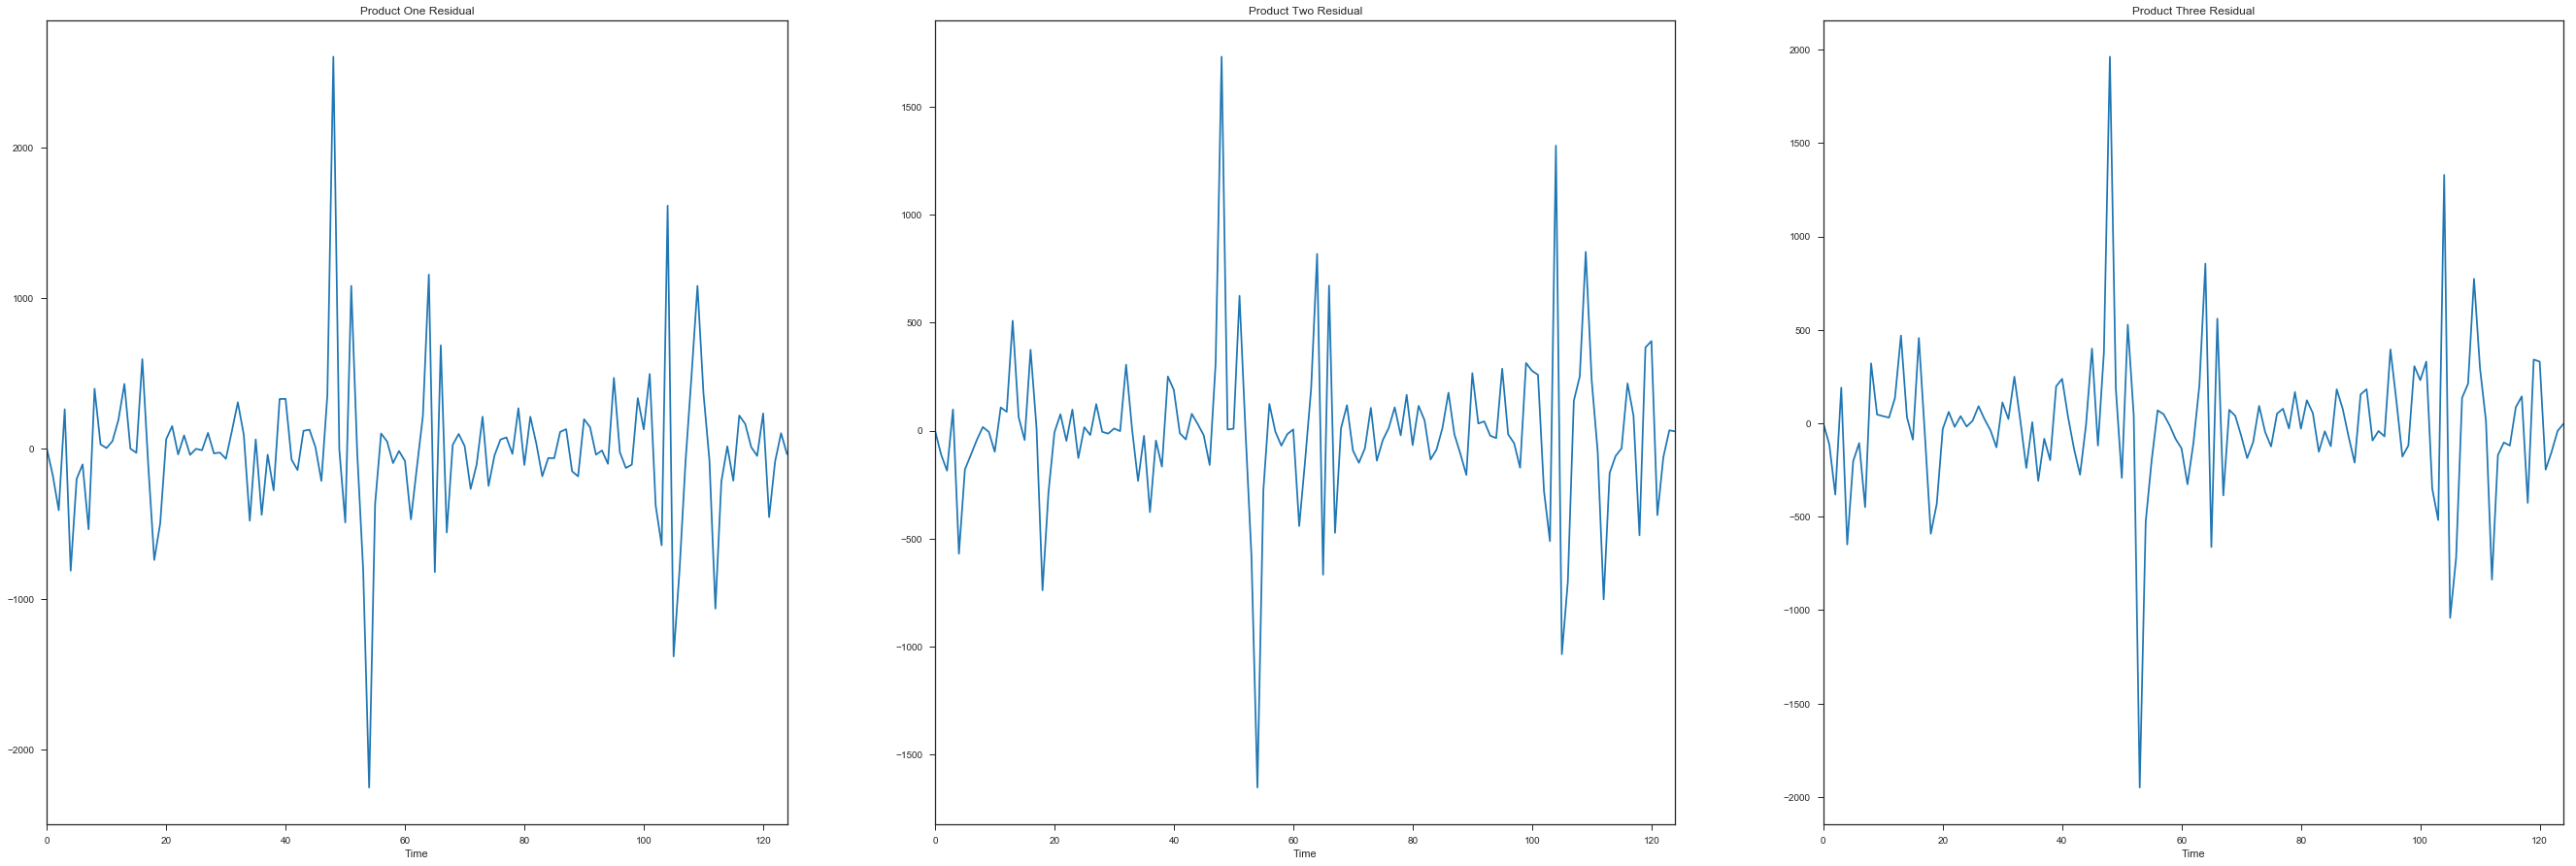

In [7]:
"""
Plot original data out.
"""
fig, axes = plt.subplots(nrows=1, ncols=3)

plt.subplot(1,3,1)
sns.tsplot(ses_resid_p1)
plt.title("Product One Residual")
plt.xlabel("Time")

plt.subplot(1,3,2)
sns.tsplot(ses_resid_p2)
plt.title("Product Two Residual")
plt.xlabel("Time")

plt.subplot(1,3,3)
sns.tsplot(ses_resid_p3)
plt.title("Product Three Residual")
plt.xlabel("Time")

# Fix up the spacing.
plt.subplots_adjust(left=5, bottom=None, right=11, top=3, wspace=None, hspace=None)
plt.show()

White Noise but noticeable changes in variance aroud Jan 2010. 

When Sale peak at aroud 4000, residual can be also more than -2000,2000, which could make ES MAPE results really bad

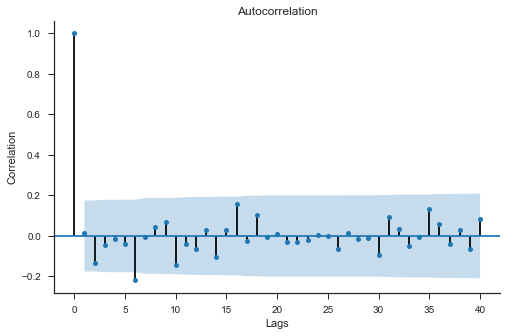

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')
ax.set_title('Correlogram for residuals')
sm.graphics.tsa.plot_acf(ses_resid_p1, lags=40, ax=ax)
sns.despine()
plt.show()

Randomness ACF of residual, no parrtern

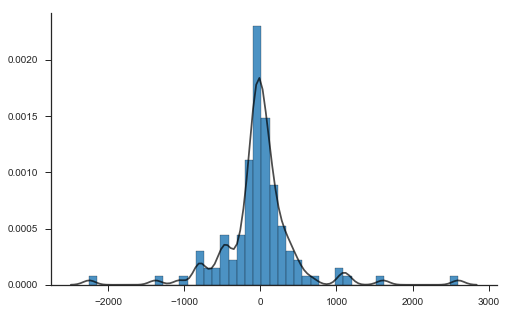

In [9]:
hist(ses_resid_p1)
plt.show()

Skewed residuals. should due to the same problem aroud Jan 2010

### SE Model validation


#### Rolling Window Forecast

In [10]:
def naive_RW_Seasonal(prod, freq, train_data, val_data):
    """
    Naive/ Random Walk Model. Use y_{t-freq} to predict y_t.
    
    Parameters
    ----------
    prod:
        Interested product 
    freq:
        The seasonal period, Integer
    train_data: dataframe
        The training set containing all products.
    val_data: dataframe
        The validation set containing all products.
        
    Returns
    --------
    results : dictionary
        Key is product and value is the MSE.
    """
    
    # Compute metric for each product.
    diff = []
    RWS_pred = []
    # Just for the freq-step ahead forecast.
    diff.append(abs(train_data[prod].iloc[len(train_data[prod])-freq] - val_data[prod].iloc[0])/abs(val_data[prod].iloc[0]))
    RWS_pred.append(val_data[prod].iloc[0])
    
    for i in range(1, len(val_data[prod])):
    # Loop through and use y_t-1 to predict y_t.
    # CHANGE THIS LINE TO CHANGE ERROR METRIC.
        diff.append(100*(abs(val_data[prod].iloc[i] - val_data[prod].iloc[i-freq])/val_data[prod].iloc[i]))
        RWS_pred.append(val_data[prod].iloc[i-freq])
        
    # Add the result to dictionary.
    rw_MAPE = sum(diff)/len(diff)
    
    return RWS_pred, rw_MAPE

In [11]:
def Rolling_Forecast(val_data, train_data, prod, freq):
    """
    Real time forecastig by Rolling Window
    
    Model
    ------
    Radom Walk
    Exponential smoothing
    AR(1)
    
    Parameters
    --------
    prod:
        Interested product
    freq:
        The seasonal period in seasonal RW, Integer
    train, test: 
        The training and test datasets.
    
    Returns
    --------
    Forecast results: 
        MAPE of each model
    """
    # data prepare
    train_data[prod] = train_data[prod].astype('float64')
    val_data[prod] = val_data[prod].astype('float64')
    
    RW_pred = []
    RWS_pred = []
    ES_pred = []
    AHW_pred = []
    ARMA_coll = [] 
    AR_coll = []
    actual = []
    
    # the updated data, which are related to window method
    val_data_reduce = val_data.copy()
    train_data_vary = train_data.copy()
    
    # real time forecasting based on test data! 
    for i in range(0, len(val_data[prod])):

        # Actual value
        actual.append(val_data[prod].iloc[i]) 
            
        # ES
        es = forecast.ses(train_data_vary[prod])
        es.fit() 
        ES_pred.append(es.forecast(1)[0]) # SES forecast
        diff2 =[] # MAPE
        diff2.append(100*(abs(ES_pred[-1] - val_data[prod].iloc[i])/val_data[prod].iloc[i])) 
        
        # Additive holt winters
        ahw = forecast.holtwinters(train_data_vary[prod], additive=True, damped=False, m=12) #
        ahw.fit()
        AHW_pred.append(ahw.forecast(1)[0]) 
        diff5 =[] # MAPE
        diff5.append(100*(abs(AHW_pred[-1] - val_data[prod].iloc[i])/val_data[prod].iloc[i])) 

        # AR(1) model
        #ar = sm.tsa.statespace.SARIMAX(train_data[prod],  order=(1, 0, 0)).fit()
        ar = ARIMA(train_data_vary[prod], order=(1,0,0)).fit()
        # sequence AR_pred
        AR_pred = ar.predict(start=val_data_reduce.index[0], end=val_data_reduce.index[-1])
        AR_coll.append(AR_pred)
        diff3 =[] # MAPE
        diff3.append(100*(abs(AR_pred[0] - val_data[prod].iloc[i])/val_data[prod].iloc[i]))
        
        # ARMA (2,2) (based on AIC selection in the following parts)
        ar = ARIMA(train_data_vary[prod], order=(2,0,2)).fit()
        ARMA_pred = ar.predict(start=val_data_reduce.index[0], end=val_data_reduce.index[-1])
        ARMA_coll.append(ARMA_pred)
        diff6 =[] # MAPE
        diff6.append(100*(abs(ARMA_pred[0] - val_data[prod].iloc[i])/val_data[prod].iloc[i]))
        
        
        ## Rolling Window  
        ## At each setp, use the most rencent n observation as training data
        train_data_vary = train_data.copy().append(val_data.head(i+1)) # add the lastest observation
        train_data_vary = train_data_vary.drop(index = train_data.index[:i]) # drop one most far away observation
        val_data_reduce = val_data_reduce.drop(index = val_data.index[i]) # delate the observation, as it add to train set
    
    # Add the result to dictionary.
    RW_pred, rw_MAPE = naive_RW_Seasonal(prod,1, train_data, val_data)
    RWS_pred, rws_MAPE = naive_RW_Seasonal(prod, freq, train_data, val_data)
    es_MAPE = sum(diff2)/len(diff2)
    ar_MAPE = sum(diff3)/len(diff3)
    ahw_MAPE = sum(diff5)/len(diff5)
    ARMA_MAPE = sum(diff6)/len(diff6)
    # print table
    columns=['Rand Walk',"Sens RW (q)",'Exp Smoothing', "Additive Hot Winter",'AR(1)', 'ARMA(2,0,2)','Actual']
    results = np.vstack([RW_pred,RWS_pred, ES_pred,AHW_pred, AR_coll, ARMA_coll, actual]).T
    results = pd.DataFrame(results, columns=columns, index=val_data.index)
    MAPE = [rw_MAPE, rws_MAPE, es_MAPE, ahw_MAPE, ar_MAPE, ARMA_MAPE]
    
    table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['MAPE'])
    for i in range(6):
        table.iloc[i,0] = MAPE[i]
    return table.round(3)
    

In [12]:
def Expanding_Forecast(val_data, train_data, prod, freq):
    """
    Real time forecastig by Rolling Window
    
    Model
    ------
    Radom Walk
    Exponential smoothing
    AR(1)
    
    Parameters
    --------
    prod:
        Interested product
    freq:
        The seasonal period in seasonal RW, Integer
    train, test: 
        The training and test datasets.
    
    Returns
    --------
    Forecast results: 
        MAPE and RMSE of each model
    """
    # data prepare
    train_data[prod] = train_data[prod].astype('float64')
    val_data[prod] = val_data[prod].astype('float64')
    
    RW_pred = []
    RWS_pred = []
    ES_pred = []
    AHW_pred = []
    ARMA_coll = [] 
    AR_coll = []
    actual = []
    
    # the updated data, which are related to window method
    val_data_reduce = val_data.copy()
    train_data_vary = train_data.copy()
    
    # real time forecasting based on test data! 
    for i in range(0, len(val_data[prod])):

        # Actual value
        actual.append(val_data[prod].iloc[i]) 
            
        # ES
        es = forecast.ses(train_data_vary[prod])
        es.fit() 
        ES_pred.append(es.forecast(1)[0]) # SES forecast
        diff2 =[] # MAPE
        diff2.append(100*(abs(ES_pred[-1] - val_data[prod].iloc[i])/val_data[prod].iloc[i])) 
        
        # Additive holt winters
        ahw = forecast.holtwinters(train_data_vary[prod], additive=True, damped=False, m=12) #
        ahw.fit()
        AHW_pred.append(ahw.forecast(1)[0]) 
        diff5 =[] # MAPE
        diff5.append(100*(abs(AHW_pred[-1] - val_data[prod].iloc[i])/val_data[prod].iloc[i])) 

        # AR(1) model
        #ar = sm.tsa.statespace.SARIMAX(train_data[prod],  order=(1, 0, 0)).fit()
        ar = ARIMA(train_data_vary[prod], order=(1,0,0)).fit()
        AR_pred = ar.predict(start=val_data_reduce.index[0], end=val_data_reduce.index[-1])
        AR_coll.append(AR_pred)
        diff3 =[] # MAPE
        diff3.append(100*(abs(AR_pred[0] - val_data[prod].iloc[i])/val_data[prod].iloc[i]))
        
        # ARMA (2,2) (based on AIC selection in the following parts)
        ar = ARIMA(train_data_vary[prod], order=(2,0,2)).fit()
        ARMA_pred = ar.predict(start=val_data_reduce.index[0], end=val_data_reduce.index[-1])
        ARMA_coll.append(ARMA_pred)
        diff6 =[] # MAPE
        diff6.append(100*(abs(ARMA_pred[0] - val_data[prod].iloc[i])/val_data[prod].iloc[i]))
        
        ## Expanding Window  
        ## At each setp, use add the lastest observation to the training data
        train_data_vary = train_data.copy().append(val_data.head(i+1)) # add the lastest observation
        val_data_reduce = val_data_reduce.drop(index = val_data.index[i]) # delate the observation, as it add to train set
     
    # Add the result to dictionary.
    RW_pred, rw_MAPE = naive_RW_Seasonal(prod, 1, train_data, val_data)
    RWS_pred, rws_MAPE = naive_RW_Seasonal(prod, freq, train_data, val_data)
    es_MAPE = sum(diff2)/len(diff2)
    ar_MAPE = sum(diff3)/len(diff3)
    ahw_MAPE = sum(diff5)/len(diff5)
    ARMA_MAPE = sum(diff6)/len(diff6)
    
    # print table
    columns=['Rand Walk',"Sens RW (q)",'Exp Smoothing', "Additive Hot Winter",'AR(1)', 'ARMA(2,0,2)','Actual']
    results = np.vstack([RW_pred,RWS_pred, ES_pred,AHW_pred, AR_coll, ARMA_coll, actual]).T
    results = pd.DataFrame(results, columns=columns, index=val_data.index)
    MAPE = [rw_MAPE, rws_MAPE, es_MAPE, ahw_MAPE, ar_MAPE, ARMA_MAPE]
    
    table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['MAPE'])
    for i in range(6):
        table.iloc[i,0] = MAPE[i]
    return table.round(3)
    

In [13]:
"""
Generate results of models prediction.
"""
# Loop over a forecast product
for prod in products:
    # Compute metric for each product.
    result1 = Rolling_Forecast(val_data, train_data, prod, 13) # the seasoality preiod is 26
    result2 = Expanding_Forecast(val_data, train_data, prod, 13)
    print('{}\n'.format(prod))
    print("Rolling Window")
    print(result1)
    print("\nExpanding Window")
    print(result2)
    print('-----------------------------------------------')

Prod_one

Rolling Window
                       MAPE
Rand Walk            25.382
Sens RW (q)          51.523
Exp Smoothing        38.390
Additive Hot Winter  54.515
AR(1)                43.276
ARMA(2,0,2)          45.780

Expanding Window
                       MAPE
Rand Walk            25.382
Sens RW (q)          51.523
Exp Smoothing        38.284
Additive Hot Winter  34.142
AR(1)                42.712
ARMA(2,0,2)          45.224
-----------------------------------------------
Prod_two

Rolling Window
                       MAPE
Rand Walk            24.343
Sens RW (q)          52.097
Exp Smoothing        39.706
Additive Hot Winter  52.359
AR(1)                45.797
ARMA(2,0,2)          48.317

Expanding Window
                       MAPE
Rand Walk            24.343
Sens RW (q)          52.097
Exp Smoothing        39.465
Additive Hot Winter  39.299
AR(1)                45.418
ARMA(2,0,2)          47.624
-----------------------------------------------
Prod_three

Rolling Window
       

Rolling window andn Expanding window just has slightly different result. 

Roughly speaking, Exp Smoothing has the overall best performance, additive hot winter is good under expanding window estimationn, and AR(1) seems also good in some cases.

Random walk is still best

### Fan Chat
Visualization interval forecast

## Model 3 : ARMA

## P and Q selection
The data is stationary, refer to Models_1_VAR notebook to view this.

We now try a selection selection processes to decide the number of lags for the AR(p) and MA(q) model.

In [17]:
def data_time(data,x):
    """
    Assist in wrangling the dataset for the draw_acf_pacf method.
    """
    y_=data.loc[:,['Date',x]]
    y_.set_index('Date',inplace=True)
    y_.index = pd.to_datetime(y_.index)
    return y_


def draw_acf_pacf(check, data):
    """
    Run ACF/PACF plot on each variable and check.
    """
    for prob in check:
        print("Product {} ".format(prob))
        fig, ax = plt.subplots(1,2, figsize=(12,3))
        y = data_time(data,prob)
        sm.graphics.tsa.plot_acf(y, lags=50, ax=ax[0])
        sm.graphics.tsa.plot_pacf(y, lags=50, ax=ax[1])
        sns.despine()
        fig.tight_layout()
        plt.show()

### Method 1: Visualization selection  based on ACF/PACF.

Product Prod_one 


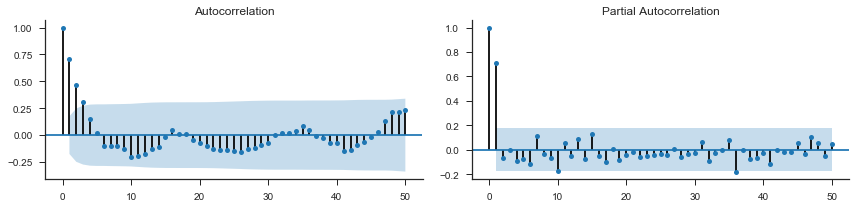

Product Prod_two 


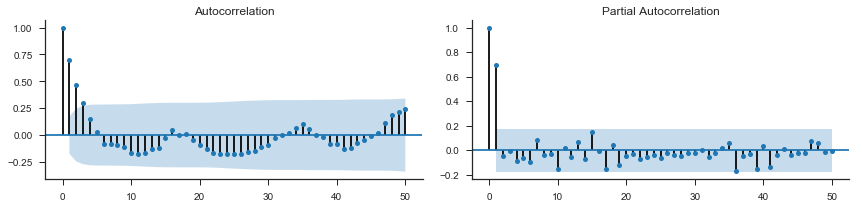

Product Prod_three 


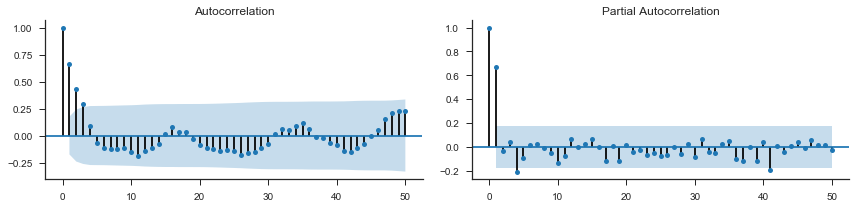

In [18]:
products = ["Prod_one", "Prod_two", "Prod_three"]
draw_acf_pacf(products, train_data)

**Analysis of graphs for product 1-3 for the AR(p) model**

From the charts, they suggest that the number of lags p should be around 3-4. The rationale is that for the autocorrelation plots, the autocorrelation decrease exponentionally after the 4 period mark. However, for the partial autocorrelation, it cuts off to zero after lag 1.

Regardless, it appears that the AR(1) only is enough, but we still check other possible combinations.

### Method 2: Information Criteria selection based on the AIC for an ARMA(P,Q) Model.


#### Model selection range

- The parameter space for p is the interval (0,2) whilst for q, it is (0,2).

#### Findings of this section:
##### Based on AIC selection

- AR(1) is suggested to be the most appropriate model.

##### Based on MAPE

- AR(1) is suggested to be the most appropriate model.


In [19]:
"""
Here, the benchMark is the AR(1) model.
"""
y = data_time(train_data,'Prod_one')
arma_benchmark=sm.tsa.statespace.SARIMAX(y, order=(1, 0, 0)).fit()

In [20]:
def aic_selection(sarima_benchmark, p, q): # initial value of p, q (benchmark)
    '''
    Forward selection based on the AIC.
    
    Parameters
    --------
    sarima_benchmark: ARMA object
        The benchmark in which to compare models agaisnt.
    p: int scalar
        Maximum number of lags to test for AR.
    q: int scalar
        Maximum number of lags to test for MA.
    
    Returns
    --------
    results: tuple
        Tuple containing optimal p,q, and AIC score.
    '''
    try:
        warnings.filterwarnings('ignore')
        best_score=sarima_benchmark.aic
        best_model=sarima_benchmark
        x1= range(3) # p from 0-2
        x3= range(3) # q from 0-2
        for i in x1:
            # Iterate through and fit different lags.
            j=0
            for k in x3:
                if (i==0 and k==0) or (i==2 and k==1):
                        continue
                model=sm.tsa.statespace.SARIMAX(y,  order=(i, j, k)).fit()
                score=model.aic
                if (score<best_score):
                    best_score=model.aic
                    p = i;q = k
    except ValueError:
        print("Note that if the following invertible p d q are printed, please add them in (if-continue), otherwise you may not get the best model ")
        print("These variable cannot build model (as cannot invertible ) when p d q :" +str(i)+" "+str(j)+" "+str(k))
        print()
    return (p, q, best_score)

In [21]:
'''
Select best ARMA model based on AIC, MAPE for each product
'''
products = ["Prod_one", "Prod_two", "Prod_three"]
results = {}
for prod in products:
    y = data_time(train_data,prod)
    arma_benchmark=sm.tsa.statespace.SARIMAX(y, order=(1, 0, 0)).fit() 
    p1, q1, best_score1 = aic_selection(arma_benchmark,1, 0)
    results.update({prod: [p1, q1,best_score1.round(2)]})

The best lags to use for each product.

In [22]:
# Just some data formatting wrangling for next block.

final_data = []
for i in range(len(results.items())):
    # Loop through product.
    temp = []
    temp.append(list(results.items())[i][0])
    for score in list(results.items())[i][1]:
        # Extract p,q, and AIC.
        temp.append(score)
    final_data.append(temp)

In [23]:
pd.DataFrame(final_data, columns=['Product','Optimal P','Optimal Q','AIC'])

,Product,Optimal P,Optimal Q,AIC
0,Prod_one,2,2,1907.07
1,Prod_two,2,2,1833.79
2,Prod_three,1,2,1856.30


Hence, it appears the consensus is generally P=1 or 2 and Q=2.

In [24]:
## 

In [25]:
'''
Compare ES model with ARMA result based on AIC for each product
'''
products = ["Prod_one", "Prod_two", "Prod_three"]
results = {}
for prod in products:
    y = data_time(train_data,prod)
    arma_benchmark=sm.tsa.statespace.SARIMAX(y, order=(0, 1, 1)).fit() 
    p1, q1, best_score1 = aic_selection(arma_benchmark, 0, 1)
    
    results.update({prod: [p1, q1,best_score1.round(2)]})